# Homework 3 (Tutorial 7)

##MA course in Artificial Intelligence 2022/2023

@author: Filippo Casari

In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

In [2]:
# Imports

#from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
#ic.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0


In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
#ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
#ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


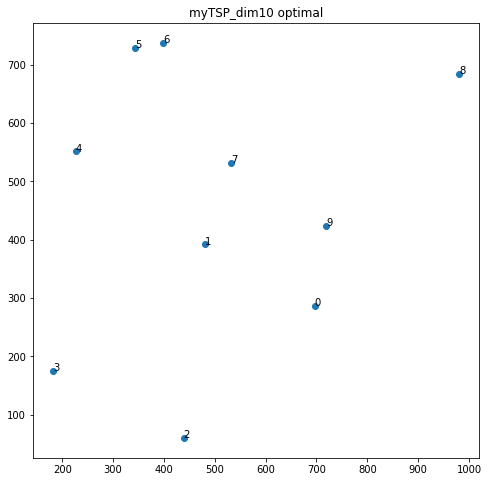

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [79]:
%matplotlib notebook
from matplotlib import pyplot as plt
from IPython import display
import time


def plot_tour(instance, tour, ant):

    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.title(f"Tour Ant # {ant}")
    plt.scatter(instance.points[:, 1], instance.points[:, 2])
    for t in range(len(tour)-1):
        xy1, xy2 = tour[t], tour[t+1]
        plt.plot([instance.points[xy1, 1], instance.points[xy2, 1]], [
                 instance.points[xy1, 2], instance.points[xy2, 2]], color="blue")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.1)
        #plt.draw()
        #plt.pause(0.2)
    # plt.show()


In [107]:
import numpy as np
import random
from solvers import local_search
from solvers.constructive_algorithms import nn
from solvers.two_opt_with_candidate import twoOpt_with_cl
from threading import Thread
from time import sleep
# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)


class ACS:
    m = 10
    beta = 2
    alpha = rho = 0.1
    cl = 15
    q0 = 0.98
    stop_after_secs = 0

    @staticmethod
    def take_candidates(j, dist_mat):
        # print(dist_mat[j][1:ACS.cl+1])

        # print(dist_mat[j][1:])
        # print(sorted(dist_mat[j])[1:ACS.cl+1])
        # print(list(np.argsort(dist_mat[j])[1:ACS.cl+1]))

        # da 1 citta vicina a 21 citta', sorting delle citta vicine
        return (np.argsort(dist_mat[j])[1:ACS.cl+1])

    @staticmethod
    def take_other_cities(j, dist_mat):
        return (np.argsort(dist_mat[j])[ACS.cl+1:])

    def __init__(self, instance, q0=None, boost=False, timeStop=180):
        """constructor

        Args:
            instance (instance of TSP_Creator): problem to solve
        """
        self.boost = boost
        self.stop_after_secs = timeStop
        if(q0 != None):
            self.q0 = q0
        self.instance = instance
        self.n = instance.nPoints
        self.dist_mat = instance.dist_matrix
        _, self.L_nn = nn(instance.dist_matrix,
                          starting_node=np.random.choice(self.n))
        self.tau0 = 1./(float(self.n) * self.L_nn)

        # position collector for the Ants, TO BE UPDATED during the steps
        self.position = {i: None for i in range(ACS.m)}
        self.tour = {i: []
                     for i in range(ACS.m)}  # tour collector for the Ants
        #self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
        self.pheromone = {r: [self.tau0]*(self.n) for r in range(self.n)}
        self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(
            self.n)}  # per tutte le citta', prende le citta vicine
        #self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}
        self.eta = {r: [1./(self.dist_mat[r, s]+np.finfo(np.double).eps)
                        for s in range(self.n)] for r in range(self.n)}
        for k in self.eta:
            self.eta[k][k] = 0.
        self.tour_len = {i: 0. for i in range(ACS.m)}
        self.best_tour = []
        self.best_ant = 0
        self.best_tour_len = 10e10
        self.iterations = 1000000
        self.tour_len_global = []
        self.current_iteration = 0
        self.tour_len_over_iters = []
        self.count_exploitation = 0
        self.count_exploration = 0
        self.best_len = 0.
        self.best_tour_tmp=[]
    def global_update(self):
        """Global pheromone updating
        """
        for k1, val1 in self.pheromone.items():

            for k2, val2 in self.pheromone.items():
                #print(self.pheromone[k1][k2], "pheromone before")
                if(k1 == k2):
                    self.pheromone[k1][k2] = 0.
                else:
                    delta_tau = 0.
                    if(k1 in self.best_tour_tmp and k2 in self.best_tour_tmp):
                        delta_tau = 1./self.best_len
                        #old = self.pheromone[k1][k2]
                        #print("delta_tau: ", delta_tau)
                    
                    self.pheromone[k1][k2] = (
                        1. - self.alpha) * self.pheromone[k1][k2] + (self.alpha * delta_tau)
                    self.pheromone[k2][k1] = (
                        1. - self.alpha) * self.pheromone[k2][k1] + (self.alpha * delta_tau)
                    '''if(k1 in self.best_tour_tmp and k2 in self.best_tour_tmp):
                        print("difference gap: ", self.pheromone[k1][k2]-old)'''
                    #print(self.pheromone[k1][k2], "pheromone after")

    def solve(self):
        """Solving ACS
        """
        threeMinutes = Thread(target=lambda: sleep(self.stop_after_secs))
        threeMinutes.start()
        for iteration in range(self.iterations):
            self.current_iteration = iteration
            # if(iteration % 5 == 0):
            #    print("iteration : ", iteration)
            self.loop()
            best_tour_ant = min(self.tour_len, key=self.tour_len.get)
            
            self.best_len = self.tour_len[best_tour_ant]
            #print(min(self.tour_len.values()))
            self.best_tour_tmp = self.tour[best_tour_ant]
            if(self.best_len < self.best_tour_len):
                self.best_tour_len = self.best_len
                self.best_ant = best_tour_ant
                self.best_tour = self.best_tour_tmp

            # print("best tour len this time: ",
            #     best_len, "by ant # ", best_tour_ant)
            if(self.boost):
                self.two_Opt_Improvement()
            self.global_update()
            self.tour_len_over_iters.append(self.best_len)
            self.tour_len_global.append(np.mean(list(self.tour_len.values())))

            if not threeMinutes.is_alive():
                break
            self.tour = {i: [] for i in range(ACS.m)}
            self.position = {i: None for i in range(self.m)}
            self.tour_len = {i: 0. for i in range(self.m)}

    def local_update(self, k):
        """local pheromone update

        Args:
            k (int): ant number
        """
        # print(self.tour)
        old_city = self.tour[k][-2]
        next_city = self.position[k]
        old_ph = self.pheromone[old_city][next_city]
        pheromon = ((1.-self.rho) * old_ph) + (self.rho * self.tau0)
        self.pheromone[old_city][next_city] = pheromon
        self.pheromone[next_city][old_city] = pheromon
        self.tour_len[k] += self.dist_mat[old_city, next_city]

        '''if(k==0):
      
      print("old ph ", old_ph)
      print(f"pherormone edges{(old_city, next_city)}")
      print("new pheromone", pheromon)#self.pheromone[old_city][next_city]'''

    def loop(self):
        """each ant contructs its own tour

        Args:
            verbose (bool, optional): log or not. Defaults to False.
        """

        for node_idx in range(self.n):
            # if(node_idx % 15 == 0):
            #    print(f"iteration #{node_idx}")
            if(node_idx < self.n-1):

                for k in range(self.m):
                    if(self.position[k] == None):
                        self.position[k] = np.random.randint(
                            low=0, high=self.n-1)
                        
                        self.tour[k].append(self.position[k])
                    q = np.random.random()

                    eta_beta = np.power(self.eta[self.position[k]], self.beta)
                    
                    s_list = eta_beta*np.array(self.pheromone[self.position[k]])
                    s_list_cities=np.argsort(s_list)
                    #print(s_list)
                    #print(s_list_cities)
                    #print(s_list)
                    #print(s_list_cities)
                    #s_list=sorted(s_list)
                    #s_dict = []

                    
                    '''
                    for s, city in zip(s_list, self.candidate_list[self.position[k]]):
                        s_dict[city] = s

                    for city in self.tour[k]:
                        s_dict.pop(city, None)
                    if(not s_dict):
                        
                        print("Finished candidate list")
                        print(len(self.tour[k]))
                        for s, city in zip(s_list, self.take_other_cities(self.position[k], self.dist_mat)):
                            if(city not in self.tour[k]):
                                s_dict[city] = s
                    # print(s_dict)
                    '''
                    
                    if(q < self.q0):
                        self.count_exploitation += 1
                        #next_city = max(s_dict, key=s_dict.get)
                        
                        for i in range(self.n):
                            if(s_list_cities[self.n-1-i] not in self.tour[k]):
                                next_city=s_list_cities[self.n-1-i]
                                break
                            
                        self.position[k] = next_city
                        self.tour[k].append(next_city)

                    else:
                        '''
                        somma_prob = sum(s_dict.values()) + \
                            np.finfo(np.float64).eps
                        for city, s in s_dict.items():
                            s_dict[city] = (s/somma_prob)
                            if(s_dict[city] == 0.):
                                s_dict[city] = np.finfo(np.float64).eps
                        somma_prob = sum(s_dict.values()) + \
                            np.finfo(np.float64).eps
                        for city, s in s_dict.items():
                            s_dict[city] = (s/somma_prob)
                        '''
                        possible_cities =[]
                        new_s_list=[]
                        for i in range(self.n):
                            if(i not in self.tour[k]):
                                new_s_list.append(s_list[i])
                            
                                possible_cities.append(i)
                        sum_val = sum(new_s_list)
                        prob = new_s_list/sum_val
                        
                        next_city = random.choices(
                            possible_cities, weights=prob, k=1)[0]

                        
                        self.tour[k].append(next_city)
                        self.position[k] = next_city

                        self.count_exploration += 1

                    self.local_update(k)
            else:
                for k in range(self.m):
                    self.tour[k].append(self.tour[k][0])
                    self.tour_len[k] += self.dist_mat[self.tour[k]
                                                      [-2], self.tour[k][-1]]

            #print("position ant 0", self.position[0])

        #print("path lengths", self.tour_len)
        '''
        if len(self.tour[k][:-1]) > len(set(self.tour[k][-1])):
            print("some repetitions")
      '''
        # if(k==0):
        #  plot_tour(self.instance, self.tour[k], k)

    def two_Opt_Improvement(self):
        #print("best tour:", len(self.best_tour))
        #print("best tour len this iter:", self.best_len)
        best_tour_new, best_tour_len_new = twoOpt_with_cl(
            self.best_tour_tmp, self.best_len, self.dist_mat, self.candidate_list)
        if(best_tour_len_new< self.best_len):
            self.best_len, self.best_tour_tmp = best_tour_len_new, best_tour_new
            if(self.best_len < self.best_tour_len):
                #print(f"initial tour: {self.best_len}. Improved by 2 opt: {best_tour_len_new}")
                self.best_tour, self.best_tour_len = best_tour_new, best_tour_len_new


In [113]:
%matplotlib tk
import pandas as pd
seeds = [0, 42, 123]
q_s = [0.5,0.98, 1.]
instances = ["eil76.tsp", "ch130.tsp", "d198.tsp"]
results = pd.DataFrame(columns=['q', 'boost', 'best integer len', '# iterations', 'AVG integer len', 'STD ', 'Optimum', 'Rel error'])
counter = -1
results.to_csv("CSV/results4.csv")
for q in q_s:
    
    list_of_len=[]
    if(q==1.):
        q = q-(13./ic.nPoints)
    print(f"-------  Q0 = {q} ---------")
    for seed in seeds:
        print(f"-------  SEED = {seed} ---------")
        random.seed(seed)
        np.random.seed(seed)
        for boost in [True, False]:
            print(f"-------  Boost/2opt = {boost} ---------")
            
            results = {i: [] for i in instances}
            for instance in instances:
                print(f"-------  INSTANCE = {instance} ---------")
                ic = TSP_Instance_Creator("standard", instance)
                
                acs = ACS(ic, q, boost, 180)
                # print(acs.pheromone)
                # print(acs.candidate_list)
                acs.solve()
                results[instance].append(q)
                results[instance].append(boost)
                results[instance].append(acs.best_tour_len)
                results[instance].append(acs.current_iteration)
                results[instance].append(np.mean(acs.tour_len_global))
                results[instance].append(np.std(acs.tour_len_global))
                results[instance].append(ic.best_sol)
                results[instance].append(((acs.best_tour_len-ic.best_sol)*100.)/ic.best_sol)
                list_of_len.append(np.mean(acs.tour_len_global))
                #plt.plot(list(range(acs.current_iteration+1)),((np.array(acs.tour_len_global)-ic.best_sol)*100.)/ic.best_sol)
                #plt.ylabel("GAP")
                #plt.xlabel("Iterations")
                #plt.title("instance"+instance)
                #plt.show()
                print("best gap (%) = " , ((acs.best_tour_len-ic.best_sol)*100.)/ic.best_sol)
                print("best cost = " , acs.best_tour_len)
                print("numbers of tours generated = ", acs.current_iteration*acs.m)
                #plt.plot(list(range(acs.current_iteration+1)),acs.tour_len_global)
                #plt.show()
            counter+=1
            results = pd.DataFrame(results).T
            results.columns = ['q', 'boost', 'best integer len', '# iterations', 'AVG integer len', 'STD ', 'Optimum', 'Rel error']
            results.to_csv("CSV/results4.csv", mode='a', header=False)
            print(results)
            
                #print(
                #    f"absulute best lenght= {acs.best_tour_len}, by ant # {acs.best_ant}. Tour:\n {acs.best_tour}")
        #plt.figure(8,8)
        #plt.plot(acs.tour_len_global, list(range(10)))
        #plt.show()
    
#print(f"difference len ACS - NN = {acs.best_tour_len - acs.L_nn}")


-------  Q0 = 0.5 ---------
-------  SEED = 0 ---------
-------  Boost/2opt = True ---------
-------  INSTANCE = eil76.tsp ---------
best gap (%) =  3.345724907063197
best cost =  556.0
numbers of tours generated =  7780
-------  INSTANCE = ch130.tsp ---------
best gap (%) =  3.355155482815057
best cost =  6315.0
numbers of tours generated =  2650
-------  INSTANCE = d198.tsp ---------


In [108]:

instance = instances[0]
ic = TSP_Instance_Creator("standard", instance)
np.random.seed(43)
acs = ACS(ic, 0.9, boost=True, timeStop=15)
#print(acs.tour_len_over_iters)
#print(acs.eta)
acs.solve()


[78 74 25 62 38 69 76  3 63 44 45 55 10 17 64 72 54 46 32 36  5 56 22 52
 27  9 43 34 29 21 53 18  4 28 75  0 24 70 39 68 13 37 20  2 47  6 40 50
 61 73  7 35 59 33 71 66 42 48 65 51 31  8 16 12 49 15 30  1 23 60 26 57
 58 77 67 11 14 41 19]
<class 'numpy.ndarray'>
exploitations=  89.89704641350211  % 
solution NN:  636.0  mine:  567.0


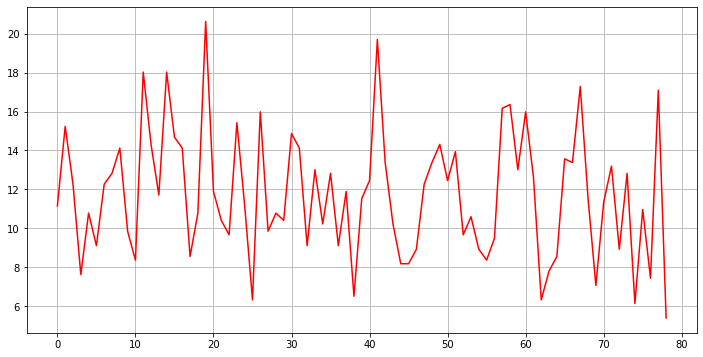

In [110]:
%matplotlib inline
print(np.argsort(acs.tour_len_over_iters[:]))
print(type(acs.tour_len_over_iters[0]))
total= float(acs.count_exploitation)+float(acs.count_exploration)
print("exploitations= ", float(acs.count_exploitation)*100/total, " % ")
print("solution NN: ", acs.L_nn, " mine: ", acs.best_tour_len)
fig= plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(list(range(int(acs.current_iteration)+1)), ((np.array(acs.tour_len_over_iters[::])-ic.best_sol)*100.)/ic.best_sol, color="red")
#plt.plot([np.argmax(acs.tour_len_over_iters), np.argmin(acs.tour_len_over_iters)], [max(acs.tour_len_over_iters), min(acs.tour_len_over_iters)], color="blue")
plt.show()

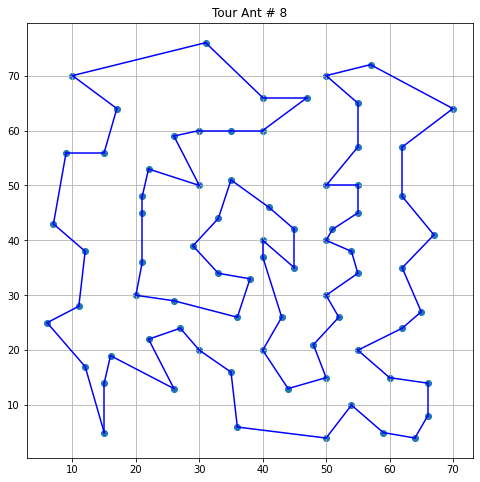

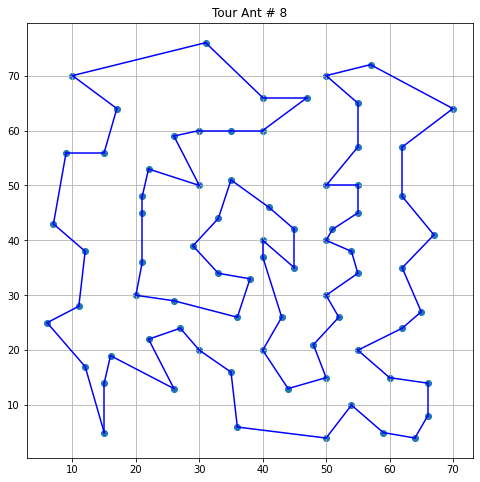

In [111]:
%matplotlib inline
plot_tour(acs.instance, acs.best_tour,acs.best_ant)


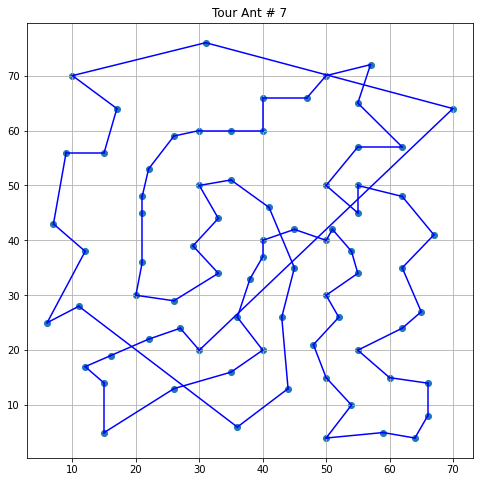

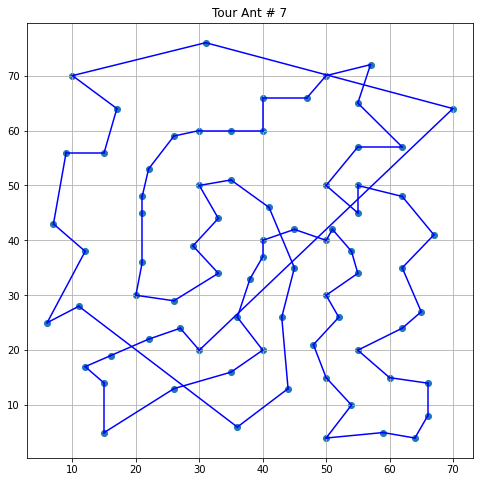

In [101]:
%matplotlib inline
t, L_nn = nn(acs.instance.dist_matrix,
                          starting_node=np.random.choice(acs.n))
t.append(t[0])
plot_tour(acs.instance, t,acs.best_ant)

# test twoOpt_with_cl 

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation